# Estimate rates from SqRA rate matrix 1D

In [10]:
from matplotlib import pyplot as plt
from scipy.linalg import rsf2csf, subspace_angles
from typing import Dict, List, Tuple, Union, Callable, Optional, TYPE_CHECKING
import copy
import numpy as np
import scipy.linalg
import scipy.sparse
import scipy.sparse.linalg


### Adjacency matrix

In [23]:
def adjancency_matrix_sparse(nbins, nd, periodic=False):
    v = np.zeros(nbins)
    v[1] = 1
    
    if periodic:
        v[-1] = 1
        A0 = scipy.sparse.csc_matrix(scipy.linalg.circulant(v)) #.toarray()
    else:
        A0 = scipy.sparse.csc_matrix(scipy.linalg.toeplitz(v)) #.toarray()
    
    A = A0
    I2 = scipy.sparse.eye(nbins)  #np.eye(nbins)
    for _ in range(1, nd):
        I1 = scipy.sparse.eye(*A.shape) #np.eye(*A.shape)
        A =  scipy.sparse.kron(A0, I1) + scipy.sparse.kron(I2, A)
    return A

### Spatial discretization (ref: http://www-cs-students.stanford.edu/~amitp/game-programming/polygon-map-generation/)

1. Randomly select your points
2. Compute midways between your points
    -> The two midways on the two sides of each point, is like
       its Voronoi polygon in the Voronoi diagram
    -> So let's call the range between these two "midways" a Voronoi range!
3. Replace each point by the center of its Voronoi range
4. If you want the values to be less random, loop back to step 2
5. The ranges you are looking for are the Voronoi ranges of the last results.

In [24]:
def find_mid(sorted_list):
        acopy = sorted(sorted_list * 2)[1:-1]
        mid = [acopy[j]+((acopy[j+1]-acopy[j])/2) for j in range(0, len(acopy),2)]
        return mid

def generating_bins(E_pot,nedges, loop=2):
    # increase loop to have less random discretization
    random_float = sorted([np.random.uniform(min(E_pot), max(E_pot)) for i in range(nedges)])
    counter = loop
    bins = None
    
    while counter != 0:
        if counter == loop:
            midpoints = find_mid(random_float)
        else:
            edge = find_mid(bins)
            midpoints = find_mid(edge)
        bins = [min(E_pot)] + copy.deepcopy(midpoints) + [max(E_pot)]
        counter -= 1
        
    return bins

## 1D system

In [25]:
# Potential energy function
def v1d(x):
    return (x**2 - 1)**2 

# System parameters
kB    = 0.008314463
T     = 300
mass  = 1
gamma = 1
D     = kB * T / mass / gamma # diffusion coefficient
sigma = np.sqrt(2 * D) # diagonal matrix
beta  = 1 / kB / T

# Grid
nd     = 1  # Number of dimensions
nedges = 60 # State boundaries
xmin   = -2.8
xmax   =  2.8

x      = np.linspace(xmin, xmax, nedges)  # array with x edges
dx     = x[1] - x[0]
x      = x[:-1] + (dx / 2)                # array with x centers
xbins  = nedges - 1
Nbins  = xbins**nd                        # number of bins

#### Build SqRA 1D

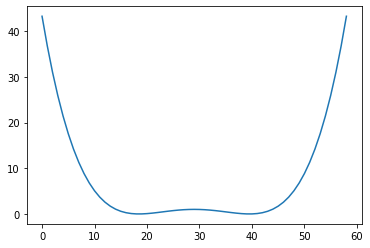

In [32]:
A  = adjancency_matrix_sparse(Nbins, nd, periodic=False)

# Potential energy of states
v = v1d(x)
#x1 = np.array([min(x)] + find_mid(generating_bins(x, nedges, loop = 10)) + [max(x)])
#x1 = np.array(find_mid(generating_bins(x, xbins, loop = 10)))
#v = v1d(x1)


# Flux
flux = D / dx**2 # Normalisation of Fick's second law?
Af   = flux * A 

# Diagonalization
SQRA = np.sqrt(np.exp(- beta * v)) # What happen to the partition function ?
SQRA = SQRA / sum(SQRA) # Normalized arithmetic mean of Boltzman density values of points in each Voronoi region
Di   = scipy.sparse.spdiags(SQRA, 0, Nbins, Nbins) # right eigenvector of Q''_c with eigenvalues close to 0
D1   = scipy.sparse.spdiags(1/SQRA, 0, Nbins, Nbins)       
Q    = D1 * Af * Di # basis transformation

Q    = Q + scipy.sparse.spdiags(-Q.sum(axis=1).T, 0, Nbins, Nbins) # compute diagonal elements of Q
eigenval, eigenvec = scipy.sparse.linalg.eigs(Q.T, 4, which='LR')
#plt.plot(v1d(x),'*')
plt.plot(v)

#### Estimate rate from xA = -1 to xB = +1

Rate from A to B:  0.7153254970609757


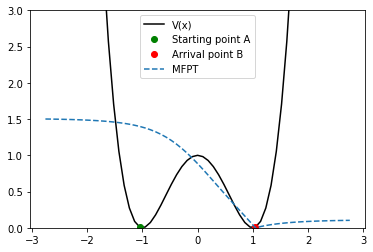

In [27]:
iA = np.argwhere(np.abs(x + 1) < 0.05).item() # index of xA
iB = np.argwhere(np.abs(x - 1) < 0.05).item() # index of xB

xA = x[iA]
xB = x[iB]

Q1         = scipy.sparse.csr_matrix.copy(Q)
Q1         = Q1.toarray()
Q1[iB, :]  = 0.0
Q1[iB, iB] = -1.0
b          = -np.ones(xbins)
b[iB]      = 0.0
m_t        = np.linalg.solve(Q1, b)
k          = 1./m_t[iA]
print('Rate from A to B: ', k)
 
plt.plot(x, v1d(x),'k',label='V(x)')
plt.plot(xA, v1d(xA), 'go',label='Starting point A')
plt.plot(xB, v1d(xB), 'ro',label='Arrival point B')
plt.plot(x,m_t,'--',label='MFPT')
plt.ylim((0,3))
plt.legend()

#### Estimate rate from set A = [-1.2, -0.7] to set B = [0.8, 1.3]

Rate from set A to set B:  0.8760825533337278


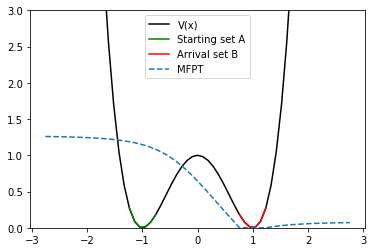

In [28]:
iAa = np.argwhere(np.abs(x + 1.2) < 0.05).item() # first index of set A
iAb = np.argwhere(np.abs(x + 0.7) < 0.05).item() # last index of set A

iBa = np.argwhere(np.abs(x - 0.8) < 0.05).item() # first index of set B
iBb = np.argwhere(np.abs(x - 1.3) < 0.05).item() # last index of set B

setA = np.arange(iAa,iAb)
setB = np.arange(iBa,iBb)

xA = x[setA]
xB = x[setB]

W   = np.exp(- beta * v)
W   = W[setA]
W   = W / np.sum(W)

Q2                   = scipy.sparse.csr_matrix.copy(Q)
Q2                   = Q2.toarray()
Q2[iBa:iBb, :]       = 0.0
Q2[iBa:iBb, iBa:iBb] = -np.eye(len(setB))

b              = -np.ones(len(Q2))
b[setB]        = 0.0
m_t            = np.linalg.solve(Q2, b)  #Mean first-passage time to set right (for all possible starting states)
m_t_sets       = np.dot(W, m_t[setA])    #Mean first-passage time from set left to set right

k              = 1./m_t_sets
print('Rate from set A to set B: ', str(k))

plt.plot(x, v1d(x),'k',label='V(x)')
plt.plot(xA, v1d(xA), 'g',label='Starting set A')
plt.plot(xB, v1d(xB), 'r',label='Arrival set B')
plt.plot(x,m_t,'--',label='MFPT')
plt.ylim((0,3))
plt.legend()

#### PCCA+

In [29]:
from scipy.optimize import fmin


EPS = np.finfo(np.float64).eps

expensive_asserts = False


def _objective(alpha: np.ndarray, X: np.ndarray) -> float:
    """
    Compute objective function value.
    Parameters
    ----------
    alpha
        Vector of shape `((m - 1) ^ 2,)` containing the flattened and
        cropped rotation matrix ``rot_matrix[1:, 1:]``.
    X
        %(Q_sort)s
    Returns
    -------
    Current value of the objective function :math:`f = m - trace(S)`
    (Eq. 16 from [Roeblitz13]_).
    """
    # Dimensions.
    n, m = X.shape
    k = m - 1

    # Initialize rotation matrix.
    rot_mat = np.zeros((m, m), dtype=np.float64)

    # Sanity checks.
    if alpha.shape[0] != k ** 2:
        raise ValueError(
            "The shape of alpha doesn't match with the shape of X: "
            f"It is not a ({k}^2,)-vector, but of dimension {alpha.shape}. X is of shape `{X.shape}`."
        )

    # Now reshape alpha into a (k,k)-matrix.
    rot_crop_matrix = np.reshape(alpha, (k, k))

    # Complete rot_mat to meet constraints (positivity, partition of unity).
    rot_mat[1:, 1:] = rot_crop_matrix
    rot_mat = _fill_matrix(rot_mat, X)

    # Compute value of the objective function.
    # from Matlab: optval = m - trace( diag(1 ./ A(1,:)) * (A' * A) )
    return m - np.trace(np.diag(1.0 / rot_mat[0, :]).dot(rot_mat.conj().T.dot(rot_mat)))  # type: ignore[no-any-return]

def _indexsearch(X: np.ndarray) -> np.ndarray:
    """
    Find a simplex structure in the data.
    Parameters
    ----------
    X
        %(Q_sort)s
    Returns
    -------
    Vector of shape `(m,)` with indices of data points that constitute the
    vertices of a simplex.
    """
    n, m = X.shape

    # Sanity check.
    if n < m:
        raise ValueError(
            f"The Schur vector matrix of shape {X.shape} has more columns than rows. "
            f"You can't get a {m}-dimensional simplex from {n} data vectors."
        )
    # Check if the first, and only the first eigenvector is constant.
    diffs = np.abs(np.max(X, axis=0) - np.min(X, axis=0))
    if not np.isclose(1.0 + diffs[0], 1.0, rtol=1e-6):
        raise ValueError(
            f"First Schur vector is not constant 1. This indicates that the Schur vectors "
            f"are incorrectly sorted. Cannot search for a simplex structure in the data. The largest deviation from 1 "
            f"is {diffs[0]}."
        )
    if not np.all(diffs[1:] > 1e-6):
        which = np.sum(diffs[1:] <= 1e-6)
        raise ValueError(
            f"{which} Schur vector(s) after the first one are constant. Probably the Schur vectors "
            "are incorrectly sorted. Cannot search for a simplex structure in the data."
        )

    # local copy of the eigenvectors
    ortho_sys = np.copy(X)

    index = np.zeros(m, dtype=np.int64)
    max_dist = 0.0

    # First vertex: row with largest norm.
    for i in range(n):
        dist = np.linalg.norm(ortho_sys[i, :])
        if dist > max_dist:
            max_dist = dist
            index[0] = i

    # Translate coordinates to make the first vertex the origin.
    ortho_sys -= np.ones((n, 1)).dot(ortho_sys[index[0], np.newaxis])
    # Would be shorter, but less readable: ortho_sys -= X[index[0], np.newaxis]

    # All further vertices as rows with maximum distance to existing subspace.
    for j in range(1, m):
        max_dist = 0.0
        temp = np.copy(ortho_sys[index[j - 1], :])
        for i in range(n):
            sclprod = ortho_sys[i, :].dot(temp)
            ortho_sys[i, :] -= sclprod * temp
            distt = np.linalg.norm(ortho_sys[i, :])
            if distt > max_dist:  # and i not in index[0:j]: #in _pcca_connected_isa() of pcca.py
                max_dist = distt
                index[j] = i
        ortho_sys /= max_dist

    return index

def _initialize_rot_matrix(X: np.ndarray) -> np.ndarray:
    """
    Initialize the rotation matrix.
    Parameters
    ----------
    X
        %(Q_sort)s
    Returns
    -------
    Initial (non-optimized) rotation matrix of shape `(m, m)`.
    """
    # Search start simplex vertices ('inner simplex algorithm').
    index = _indexsearch(X)

    # Local copy of the Schur vectors.
    # Xc = np.copy(X)

    # Raise or warn if condition number is (too) high.
    condition = np.linalg.cond(X[index, :])
    if condition >= (1.0 / EPS):
        raise ValueError(
            f"The condition number {condition} of the matrix of start simplex vertices "
            "X[index, :] is too high for safe inversion (to build the initial rotation matrix)."
        )
    if condition > 1e4:
        warnings.warn(
            f"The condition number {condition} of the matrix of start simplex vertices "
            "X[index, :] is quite high for safe inversion (to build the initial rotation matrix)."
        )

    # Compute transformation matrix rot_matrix as initial guess for local optimization (maybe not feasible!).
    return np.linalg.pinv(X[index, :])


def _fill_matrix(rot_matrix: np.ndarray, X: np.ndarray) -> np.ndarray:
    """
    Make the rotation matrix feasible.
    Parameters
    ----------
    rot_matrix
        (Infeasible) rotation matrix of shape `(m, m)`.
    X
        %(Q_sort)s
    Returns
    -------
    Feasible rotation matrix of shape `(m, m)`.
    """
    n, m = X.shape

    # Sanity checks.
    if not (rot_matrix.shape[0] == rot_matrix.shape[1]):
        raise ValueError("Rotation matrix isn't quadratic.")
    if not (rot_matrix.shape[0] == m):
        raise ValueError("The dimensions of the rotation matrix don't match with the number of Schur vectors.")

    # Compute first column of rot_mat by row sum condition.
    rot_matrix[1:, 0] = -np.sum(rot_matrix[1:, 1:], axis=1)

    # Compute first row of A by maximum condition.
    dummy = -np.dot(X[:, 1:], rot_matrix[1:, :])
    rot_matrix[0, :] = np.max(dummy, axis=0)

    # Reskale rot_mat to be in the feasible set.
    rot_matrix = rot_matrix / np.sum(rot_matrix[0, :])

    # Make sure, that there are no zero or negative elements in the first row of A.
    if np.any(rot_matrix[0, :] == 0):
        raise ValueError("First row of rotation matrix has elements = 0.")
    if np.min(rot_matrix[0, :]) < 0:
        raise ValueError("First row of rotation matrix has elements < 0.")

    return rot_matrix

def _opt_soft(X: np.ndarray, rot_matrix: np.ndarray) -> Tuple[np.ndarray, np.ndarray, float]:
    r"""
    Optimize the G-PCCA rotation matrix such that the memberships are
    exclusively non-negative and compute the membership matrix.
    Parameters
    ----------
    X
        %(Q_sort)s
    rot_matrix
        Initial (non-optimized) rotation matrix of shape `(m, m)`.
    Returns
    -------
    Triple of the following:
    rot_matrix
        %(rot_matrix_ret)s
    chi
        %(chi_ret)s
    fopt
        Optimal value of the objective function :math:`f_{opt} = m - \\mathtt{trace}(S)`
        (Eq. 16 from [Roeblitz13]_).
    """  # noqa: D205, D400
    n, m = X.shape

    # Sanity checks.
    if not (rot_matrix.shape[0] == rot_matrix.shape[1]):
        raise ValueError("Rotation matrix isn't quadratic.")
    if not (rot_matrix.shape[0] == m):
        raise ValueError("The dimensions of the rotation matrix don't match with the number of Schur vectors.")
    if rot_matrix.shape[0] < 2:
        raise ValueError(f"Expected the rotation matrix to be at least of shape (2, 2), found {rot_matrix.shape}.")

    # Reduce optimization problem to size (m-1)^2 by cropping the first row and first column from rot_matrix
    rot_crop_matrix = rot_matrix[1:, 1:]

    # Now reshape rot_crop_matrix into a linear vector alpha.
    k = m - 1
    alpha = np.reshape(rot_crop_matrix, k ** 2)
    # TODO: Implement Gauss Newton Optimization to speed things up esp. for m > 10
    alpha, fopt, _, _, _ = fmin(_objective, alpha, args=(X,), full_output=True, disp=False)

    # Now reshape alpha into a (k,k)-matrix.
    rot_crop_matrix = np.reshape(alpha, (k, k))

    # Complete rot_mat to meet constraints (positivity, partition of unity).
    rot_matrix[1:, 1:] = rot_crop_matrix
    rot_matrix = _fill_matrix(rot_matrix, X)

    # Compute the membership matrix.
    chi = np.dot(X, rot_matrix)

    # Check for negative elements in chi and handle them.
    if np.any(chi < 0.0):
        if np.any(chi < -1e4 * EPS):
            min_el = np.min(chi)
            raise ValueError(f"Some elements of chi are significantly negative. The minimal element in chi is {min_el}")
        else:
            chi[chi < 0.0] = 0.0
            chi = np.true_divide(1.0, np.sum(chi, axis=1))[:, np.newaxis] * chi
            if not np.allclose(np.sum(chi, axis=1), 1.0, atol=1e-8, rtol=1e-5):
                dev = np.max(np.abs(np.sum(chi, axis=1) - 1.0))
                raise ValueError(
                    f"The rows of chi don't sum up to 1.0 after rescaling. Maximum deviation from 1 is {dev}"
                )

    return rot_matrix, chi, fopt

def sort_real_schur(
    Q: np.ndarray, R: np.ndarray, z: str, b: float, inplace: bool = False
) -> Tuple[np.ndarray, np.ndarray, List[float]]:
    r"""
    Partially or completely sort the real Schur form `R` and  Schur vectors `Q` of a square matrix `A`.
    The diagonal blocks of `R` will be ordered with respect to a target `z`.
    The blocks on the diagonal are associated with either real eigenvalues,
    in case of 1x1 blocks, or pairs of complex eigenvalues, in case of 2x2 blocks.
    The number of ordered blocks is determined by a parameter `b`.
    A vector `ap` warns for inaccuracy of the solution, if an entry of `ap` exceeds one.
    This function is based on MATLAB code originally published by Brandts [Brandts02]_.
    Parameters
    ----------
    Q
        Orthogonal real matrix `Q` of Schur vectors such that :math:`AQ = QR`.
    R
        Quasi-triangular real Schur form `R` such that :math:`AQ = QR`.
    %(z)s
    b
        Determines the length of the ordering with respect to `z`.
        Valid options are:
            - ``b < 0``: ``-b`` blocks will be sorted.
            - ``b > 0``: b or ``b + 1`` eigenvalues will be sorted,
              depending on the sizes of the blocks.
            - ``b = 0``: the whole Schur form will be sorted.
    inplace
        Determines, if the supplied `Q` and `R` matrices are sorted in place (``ìnplace = True``) or
        if copies are made and sorted (``inplace = False``; default).
    Returns
    -------
    Tuple of the following:
        - Q : orthogonal real `(n, n)` Schur vector matrix `Q` such that :math:`AQ = QR`
          with the diagonal blocks ordered with respect to the target `z`.
        - R : quasi-triangular real `(n, n)` Schur matrix `R` such that :math:`AQ = QR`
          with the diagonal blocks ordered with respect to the target `z`.
        - ap : A list `ap` warns for inaccuracy of the solution, if an entry of `ap` exceeds one.
    """  # noqa: D401
    eps = np.finfo(R.dtype).eps
    if not np.all(np.abs(np.tril(R, -2)) <= 100 * eps):
        raise ValueError("R is not block-triangular.")
    if not inplace:
        Q = Q.copy()
        R = R.copy()

    r = np.where(np.abs(np.diag(R, -1)) > 100 * eps)[0]  # detect sub-diagonal nonzero entries
    s = [
        i for i in range(R.shape[0] + 1) if i not in r + 1
    ]  # construct from them a vector s with the-top left positions of each block

    p = np.empty((len(s) - 1,), dtype=np.complex128)

    for k in range(1, len(s) - 1):  # debug
        assert R[s[k], s[k] - 1] <= 100 * eps  # debug

    for k in range(len(s) - 1):  # ranging over all blocks
        sk = s[k]
        if s[k + 1] - sk == 2:  # if the block is 2x2
            Q, R = normalize(Q, R, slice(sk, s[k + 1]), inplace=True)  # normalize it
            # store the eigenvalues
            p[k] = R[sk, sk] + np.lib.scimath.sqrt(R[sk + 1, sk] * R[sk, sk + 1])  # type: ignore[attr-defined]
        else:  # (the one with the positive imaginary part is sufficient)
            assert s[k + 1] - sk == 1  # debug
            p[k] = R[s[k], s[k]]  # if the block is 1x1, only store the eigenvalue

    ap = []

    for k in swaplist(p, s, z, b):  # For k ranging over all neighbor-swaps
        assert k + 2 < len(s)  # debug
        v = list(range(s[k], s[k + 1]))  # collect the coordinates of the blocks
        w = list(range(s[k + 1], s[k + 2]))
        assert v[0] != w[0]  # debug
        if len(v) == 2:
            assert v[0] < v[1]  # debug
        if len(w) == 2:
            assert w[0] < w[1]  # debug
        if (
            __debug__ and expensive_asserts
        ):  # debug: check that we are moving the larger eigenvalues to the left (expensive test)
            if v[0] < w[0]:  # debug
                arr = [p[k], p[k + 1]]  # debug
                _, which = select(arr, z)  # debug
                assert which == 1  # debug
            else:  # debug
                arr = [p[k + 1], p[k]]  # debug
                _, which = select(arr, z)  # debug
                assert which == 1  # debug
        vw = v + w
        nrA = np.linalg.norm(R[vw, :][:, vw], ord=np.inf)  # compute norm of the matrix A from eq. (6)
        Q, R = swap(Q, R, v, w, inplace=True)  # swap the blocks
        p[k], p[k + 1] = p[k + 1], p[k]  # debug
        s[k + 1] = s[k] + s[k + 2] - s[k + 1]  # update positions of blocks
        v = list(range(s[k], s[k + 1]))  # update block-coordinates
        w = list(range(s[k + 1], s[k + 2]))
        if len(v) == 2:  # if the first block is 2 x 2
            Q, R = normalize(Q, R, v, inplace=True)  # normalize it
        if len(w) == 2:  # if the second block is 2 x 2
            Q, R = normalize(Q, R, w, inplace=True)  # normalize it
        ap.append(
            np.linalg.norm(R[w, :][:, v], ord=np.inf) / (10 * eps * nrA)
        )  # measure size of bottom-left block (see p.6, Sect. 2.3)

    R = R - np.tril(R, -2)  # Zero the below-block entries
    for k in range(1, len(s) - 1):  # to get a quasi-triangle again
        R[s[k], s[k] - 1] = 0

    return Q, R, ap

def swaplist(p: Union[np.ndarray, List[float]], s: List[int], z: str, b: float) -> List[int]:
    """
    Produce a list `v` of swaps of neighboring blocks needed to order the eigenvalues assembled in the vector `p` \
    from closest to `z` to farthest away from `z`, taking into account the parameter `b`.
    To do so, Python's :func:`sorted`, producing a stable sort, is used to realize
    the objective ordering of the diagonal blocks. This objective ordering
    can easily be defined, since all eigenvalues can be extracted from the
    given real Schur form. This, in turn, results in an objective
    permutation of the given ordering, which can be realized by `n` swaps
    of neighboring pairs, to be represented by a swaplist `v`.
    p
        List of eigenvalues (only one copy for each complex-conjugate pair).
    s
        List of the the-top left positions of each block.
    %(z)s
    b
        Determines the length of the ordering with respect to `z`.
        Valid options are:
            - ``b < 0``: ``-b`` blocks will be sorted.
            - ``b > 0``: b or ``b+1`` eigenvalues will be sorted, depending on the sizes of the blocks.
            - ``b = 0``: the whole Schur form will be sorted.
    Returns
    -------
    Swaplist `v`, where ``v[j] = k`` means that in the `j`-th swap, the `k`-th and `k+1`-th block should be swapped.
    """
    p_orig = p  # debug
    n = len(p)
    p = list(p)
    k = 0
    v: List[int] = []
    srtd = 0  # Number of sorted eigenvalues.
    q = list(np.diff(s))  # Compute block sizes.
    q_orig = list(q)  # debug
    fini = False
    while not fini:
        _, j = select(p[k:n], z)  # Determine which block will go to position k
        p_j = p[k + j]  # debug
        p[k : n + 1] = [p[j + k]] + p[k:n]  # insert this block at position k,
        assert p[k] == p_j  # debug
        del p[j + k + 1]  # and remove it from where it was taken.
        if expensive_asserts and __debug__:
            assert np.all(sorted(p) == sorted(p_orig))  # debug
        q_j = q[k + j]  # debug
        q[k : n + 1] = [q[j + k]] + q[k:n]  # Similar for the block-sizes
        assert q[k] == q_j  # debug
        del q[j + k + 1]
        if expensive_asserts and __debug__:
            assert np.all(sorted(q) == sorted(q_orig))  # debug
        v = v + list(range(k, j + k))[::-1]  # Update the list of swaps for this block
        srtd = srtd + q[k]  # Update the number of sorted eigenvalues
        k += 1
        fini = k >= n - 1 or k == -b or srtd == b or (srtd == b + 1 and b != 0)
    return v

def select(p: Union[List[str], np.ndarray], z: str) -> Tuple[float, int]:
    """
    Determine which block is next in the ordering (needed in :func:`normalize`).
    Parameters
    ----------
    p
        List of eigenvalues.
    %(z)s
    Returns
    -------
    Block that is next in the ordering.
    """
    if z == "LM":
        pos = int(np.argmax(np.abs(p)))
        return np.abs(p[pos]), pos
    elif z == "LR":
        pos = int(np.argmax(np.real(p)))
        return np.real(p[pos]), pos
    else:
        raise NotImplementedError(z)

def _gram_schmidt_mod(X: np.ndarray, eta: np.ndarray) -> np.ndarray:
    r"""
    :math:`\eta`-orthonormalize Schur vectors.
    This uses a modified, numerically stable version of Gram-Schmidt
    Orthonormalization.
    Parameters
    ----------
    X
        Array of shape `(n, m)` consisting columnwise of the `m` dominant
        Schur vectors of :math:`\tilde{P} = \mathtt{diag}(\sqrt{\eta}) P \mathtt{diag}(1.0. / \sqrt{eta})`.
    %(eta)s
    Returns
    -------
    Array of shape `(n, m)` with the orthonormalized `m` dominant Schur
    vectors of :math:`\tilde{P}` in columns.
    The elements of the first column are constantly equal :math:`\sqrt{eta}`.
    """
    # Keep copy of the original (Schur) vectors for later sanity check.
    Xc = np.copy(X)

    # Initialize matrices.
    n, m = X.shape
    Q = np.zeros((n, m))
    R = np.zeros((m, m))

    # Search for the constant (Schur) vector, if explicitly present.
    max_i = 0
    for i in range(m):
        vsum = np.sum(X[:, i])
        dummy = np.ones(X[:, i].shape) * (vsum / n)
        if np.allclose(X[:, i], dummy, rtol=1e-6, atol=1e-5):
            max_i = i  # TODO: check, if more than one vec fulfills this

    # Shift non-constant first (Schur) vector to the right.
    X[:, max_i] = X[:, 0]
    # Set first (Schur) vector equal sqrt(eta) (In _do_schur() the Q-matrix, orthogonalized by
    # _gram_schmidt_mod(), will be multiplied with 1.0./sqrt(eta) - so the first (Schur) vector will
    # become the unit vector 1!).
    X[:, 0] = np.sqrt(eta)
    # Raise, if the subspace changed!
    dummy = subspace_angles(X, Xc)
    if not np.allclose(dummy, 0.0, atol=1e-7, rtol=1e-5):
        raise ValueError(
            "The subspace of Q derived by shifting a non-constant first (Schur)vector "
            "to the right and setting the first (Schur) vector equal sqrt(eta) doesn't "
            f"match the subspace of the original Q! The subspace angles are: {dummy}. "
            f"Number of clusters: {m}."
        )

    # eta-orthonormalization
    for j in range(m):
        v = X[:, j]
        for i in range(j):
            R[i, j] = np.dot(Q[:, i].conj(), v)
            v = v - np.dot(R[i, j], Q[:, i])
        R[j, j] = np.linalg.norm(v)
        Q[:, j] = np.true_divide(v, R[j, j])

    # Raise, if the subspace changed!
    dummy = subspace_angles(Q, Xc)
    if not np.allclose(dummy, 0.0, atol=1e-7, rtol=1e-5):
        raise ValueError(
            "The subspace of Q derived by eta-orthogonalization doesn't match the "
            f"subspace of the original Q! The subspace angles are: {dummy}. "
            f"Number of clusters: {m}."
        )
    # Raise, if the (Schur)vectors aren't orthogonal!
    if not np.allclose(Q.conj().T.dot(Q), np.eye(Q.shape[1]), atol=1e-8, rtol=1e-5):
        dev = np.max(np.abs(Q.conj().T.dot(Q) - np.eye(Q.shape[1])))
        raise ValueError(
            f"(Schur)vectors do not appear to be orthogonal. Largest absolute element-wise deviation in "
            f"(Q^*TQ - I) is {dev}"
        )

    return Q

### Apply PCCA+

[0.00000000e+00 0.00000000e+00 0.00000000e+00 3.78447348e-05
 1.86692656e-01 1.28936690e+00]


/home/jung42/miniconda3/lib/python3.8/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:322: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/home/jung42/miniconda3/lib/python3.8/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:215: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


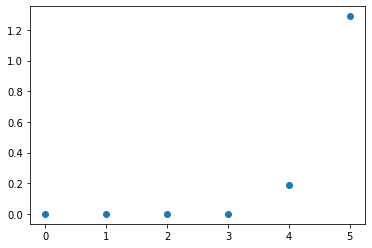

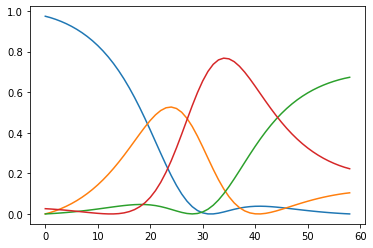

In [30]:
r = 4 # number of conformations
#eigenval, eigenvec = scipy.sparse.linalg.eigs(Q.T, r, which='LR')
Q1 = scipy.sparse.csr_matrix.copy(Q)
Q1 = scipy.linalg.expm(Q1)
U, s, _ = scipy.sparse.linalg.svds(Q1.T)
print(s)
plt.plot(s,'o')
plt.show()

Q2 = scipy.sparse.csr_matrix.toarray(Q1)
R, Q_new = scipy.linalg.schur(Q2, output='real')
Q_new,R, ap = sort_real_schur(Q_new,R,'LM',r)
T, _ = rsf2csf(R, Q_new)
eigenvalues = np.diag(T)[:r]
Q, R, eigenvalues = Q_new[:, :r], R[:r, :r], eigenvalues[:r] # sorted_schur

eta = np.true_divide(np.ones(Q.shape[0]), Q.shape[0])
if not np.allclose(Q.T.dot(Q * eta[:, None]), np.eye(Q.shape[1]), rtol=1e6 * EPS, atol=1e6 * EPS): # do_schur
        Q = _gram_schmidt_mod(Q, eta)
        # Transform the orthonormalized Schur vectors of P_bar back
        # to orthonormalized Schur vectors X of P.
        X = np.true_divide(Q, np.sqrt(eta)[:, None])
else:
        # Search for the constant (Schur) vector, if explicitly present.
        n, m = Q.shape
        max_i = 0
        for i in range(m):
            vsum = np.sum(Q[:, i])
            dummy = np.ones(Q[:, i].shape) * (vsum / n)
            if np.allclose(Q[:, i], dummy, rtol=1e-6, atol=1e-5):
                max_i = i  # TODO: check, if more than one vec fulfills this

        # Shift non-constant first (Schur) vector to the right.
        Q[:, max_i] = Q[:, 0]
        # Transform the orthonormalized Schur vectors of P_bar back
        # to orthonormalized Schur vectors X of P.
        X = np.true_divide(Q, np.sqrt(eta)[:, None])
        # Set first (Schur) vector equal 1.
        X[:, 0] = 1.0


rot_matrix = _initialize_rot_matrix(X)
rot_matrix, chi, fopt = _opt_soft(X, rot_matrix) # membership functions
crispness = (r - fopt) / r

plt.plot(chi)
plt.show()


